# TimeSeries Citi Bike Analysis

This notebook will look at a timeseries analysis using the New York, Citi Bike data.  The goal is to predict based on the day of the week and the time of the day, how many people will rent bikes from a particular location.

The focus with this notebook will be on timeseries data and how to make predictions with timeseries data.

Not every model can be used with timeseries data when predicting future events.  In addition, it is not always possible to just use the timestamp of the date/time of the event.  Sometimes you need to look at adding dummy variables for day of the week, holidy, weekend, etc.

The citibike data is in the data directory in a file named:  *citibike.csv*

This is a summary of:
### Introduction to Machine Learning with Python: A Guide for Data Scientists
- Book by Andreas Muller and Sarah Guido is a very consumeable guide to machine learning with great insight into the field.
- Chapter 4, Utilizing Expert Knowledge.


In [6]:
import mglearn
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd

In [10]:
citibike = mglearn.datasets.load_citibike()

In [8]:
citibike.head()

starttime
2015-08-01 00:00:00     3.0
2015-08-01 03:00:00     0.0
2015-08-01 06:00:00     9.0
2015-08-01 09:00:00    41.0
2015-08-01 12:00:00    39.0
Freq: 3H, Name: one, dtype: float64

As you can see, the data consists only of a datatime column and the number of bikes rented in the 3 hour bucket of time.

Lets create a line plot of the timeseries and the number of bikes rented:


Text(0,0.5,'Rentals')

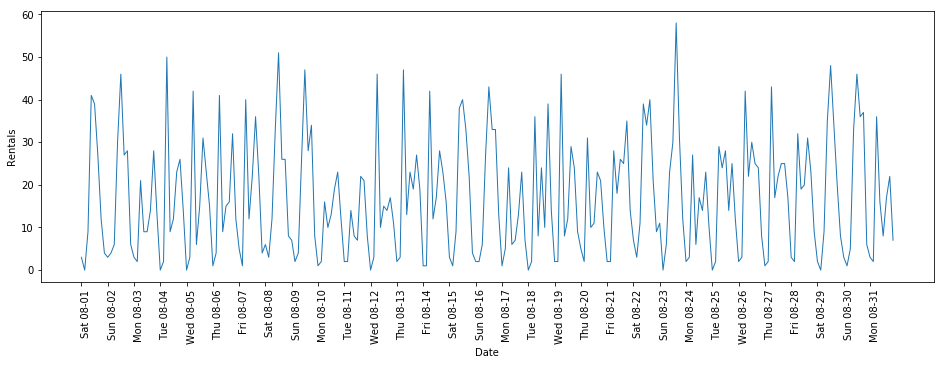

In [11]:
plt.figure(figsize=(16,5))
xticks = pd.date_range(start=citibike.index.min(), end=citibike.index.max(), freq='D')
plt.xticks(xticks.astype("int"), xticks.strftime("%a %m-%d"), rotation=90, ha='left')
plt.plot(citibike, linewidth=1)
plt.xlabel("Date")
plt.ylabel("Rentals")

Visualizing the data, we can see various patterns for day/night, weekday/weekend.  When performing a prediction task on a time series, we usually want to learn from the past to predict the future.  The means when we do the train_test_split, we **cannot** take a random sample but instead we want to take all data up to a particular point in time as the training data, and all data past that point in time as test data.  

Looking at the data set, as it is, there is a single feature: *startime*.  

As a first attempt, lets use the startime in the unix timestamp format and try to train a model.


### Use starttime as a posix milliseconds from Janary 1970

In [13]:
# Extract target values:
y = citibike.values

# convert the starttime to posix time by dividing by 10**9
# the starttime is the index column, and we want to convert to an integer value
# once we have the integer values, reshape to have all of the rows and a single column
# then divide by 10**9
X = citibike.index.astype("int64").values.reshape(-1,1) // 10**9

There are 248 samples.  We would like to hold out some for training and some for test.

In [15]:
print(y.shape)
print(X.shape)

(248,)
(248, 1)


In [16]:
# use the first 184 for training data
n_train = 184

In [20]:
# Function to evaluate and plot a regressor on a given feature set.
# This function will take the feature set and the target set and create a train/test split.  
# It will then use the regressor model to evaluate how the model is doing and plot the results.

# NOTE: this is taken verbatime from the reference above:
# function to evaluate and plot a regressor on a given feature set
def eval_on_features(features, target, regressor):
    # split the given features into a training and a test set
    X_train, X_test = features[:n_train], features[n_train:]
    # also split the target array 
    y_train, y_test = target[:n_train], target[n_train:]
    regressor.fit(X_train, y_train)
    print("Test-set R^2: {:.2f}".format(regressor.score(X_test, y_test)))
    y_pred = regressor.predict(X_test)
    y_pred_train = regressor.predict(X_train)
    plt.figure(figsize=(16, 5))

    plt.xticks(range(0, len(X), 8), xticks.strftime("%a %m-%d"), rotation=90,
               ha="left")

    plt.plot(range(n_train), y_train, label="train")
    plt.plot(range(n_train, len(y_test) + n_train), y_test, '-', label="test")
    plt.plot(range(n_train), y_pred_train, '--', label="prediction train")

    plt.plot(range(n_train, len(y_test) + n_train), y_pred, '--',
             label="prediction test")
    plt.legend(loc=(1.01, 0))
    plt.xlabel("Date")
    plt.ylabel("Rentals")

## RandomForestRegressor

Lets try to use the RandomForestRegressor to predict the future bike rentals.  

Test-set R^2: -0.04


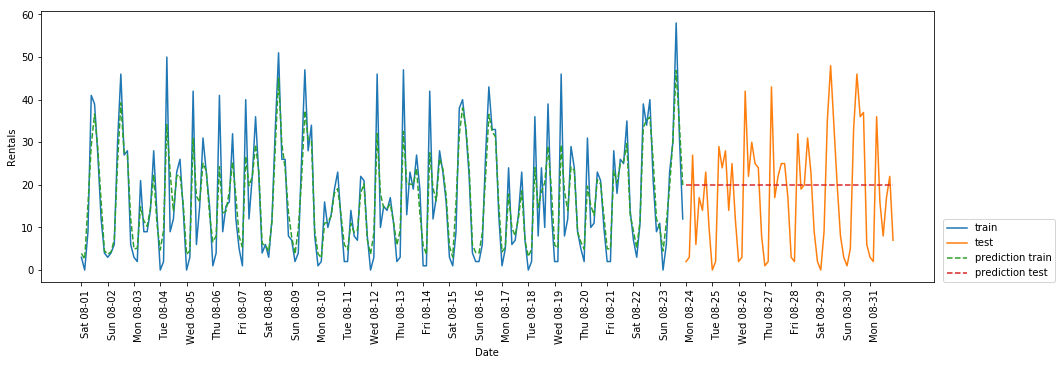

In [21]:
from sklearn.ensemble import RandomForestRegressor
regressor = RandomForestRegressor(n_estimators=100, random_state=0)
eval_on_features(X, y, regressor)

Notice the flat line for the *prediction test* which means the RandomForestRegressor predicted a constant value which is the last value predicted.

This is a very important feature, or limitation, of Tree based models.  Trees, including the RandomForest, 

**CANNOT EXTRAPOLATE TO FEATURE RANGES OUTSIDE THE TRAINING SET**

Because this is a time service, our training set includes past values, the but the test set are all future values.  Therefore we **cannot** use a RandomForestRegressor.



## Feature Engineering

Looking at the data we can see that *time of day* and *day of week* seem to be important attributes of the data set.  We can see the fluctuation in the number of rentals.

Lets create a couple of new features.